In [477]:
!pip install pmdarima

In [478]:
!pip install kaggle

In [479]:
import os
import urllib
import requests
import datetime
import math
import pickle
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import folium
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from folium import plugins
from folium.plugins import HeatMap
from functools import reduce
from scipy import stats
from scipy.stats import expon
from scipy.stats import poisson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from pmdarima.arima.stationarity import ADFTest
from pmdarima import model_selection
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric, add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics
from yellowbrick.classifier import ConfusionMatrix
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from io import BytesIO 


In [480]:
files = {'customers'    : '/content/drive/MyDrive/Datasets/olist_customers_dataset.csv',
         'geolocation'  : '/content/drive/MyDrive/Datasets/olist_geolocation_dataset.csv',
         'items'        : '/content/drive/MyDrive/Datasets/olist_order_items_dataset.csv',
         'payment'      : '/content/drive/MyDrive/Datasets/olist_order_payments_dataset.csv',
         'orders'       : '/content/drive/MyDrive/Datasets/olist_orders_dataset.csv',
         'products'     : '/content/drive/MyDrive/Datasets/olist_products_dataset.csv',
         'sellers'      : '/content/drive/MyDrive/Datasets/olist_sellers_dataset.csv',
         'review'       : '/content/drive/MyDrive/Datasets/olist_order_reviews_dataset.csv',
         }

dfs = {}
for key, value in files.items():
  dfs[key] = pd.read_csv(value, on_bad_lines='skip')

In [481]:
customers_location = dfs['customers'].merge(dfs['geolocation'], how='inner', left_on='customer_zip_code_prefix', 
                                      right_on='geolocation_zip_code_prefix').drop_duplicates('customer_id', keep='first')

In [482]:
cusloc_order = customers_location.merge(dfs['orders'], how='inner', on='customer_id')

In [483]:
cuslocord_item = cusloc_order.merge(dfs['items'], how='inner', on='order_id')

In [484]:
cuslocordite_prod = cuslocord_item.merge(dfs['products'], how='inner', on='product_id')

In [485]:
cuslocordite_rev= cuslocordite_prod.merge(dfs['review'], how='left', on='order_id')

In [486]:
dataset = cuslocordite_rev[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state',
       'geolocation_lat', 'geolocation_lng','order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_photos_qty',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp']]

In [487]:
dates = ['order_purchase_timestamp'
        ,'order_purchase_timestamp'
        ,'order_delivered_carrier_date'
        ,'order_delivered_customer_date'
        ,'order_estimated_delivery_date'
        ,'shipping_limit_date'
        ,'review_creation_date'
        ,'review_answer_timestamp' 
        ]

In [488]:
for date in dates:
    dataset[date] = pd.to_datetime(dataset[date])

In [489]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113015 entries, 0 to 113014
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    113015 non-null  object        
 1   customer_unique_id             113015 non-null  object        
 2   customer_zip_code_prefix       113015 non-null  int64         
 3   customer_city                  113015 non-null  object        
 4   customer_state                 113015 non-null  object        
 5   geolocation_lat                113015 non-null  float64       
 6   geolocation_lng                113015 non-null  float64       
 7   order_id                       113015 non-null  object        
 8   order_status                   113015 non-null  object        
 9   order_purchase_timestamp       113015 non-null  datetime64[ns]
 10  order_approved_at              113000 non-null  object        
 11  

In [490]:
dataset['delivery_time'] = (dataset['order_delivered_customer_date'].dt.date - dataset['order_purchase_timestamp'].dt.date).dt.days

In [491]:
dataset = dataset[(dataset['order_purchase_timestamp'].dt.year > 2016) 
              & 
              (dataset['order_purchase_timestamp'] < pd.to_datetime('20180901'))
             ]

In [492]:
dataset = dataset.reset_index(drop=True)

In [493]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112639 entries, 0 to 112638
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    112639 non-null  object        
 1   customer_unique_id             112639 non-null  object        
 2   customer_zip_code_prefix       112639 non-null  int64         
 3   customer_city                  112639 non-null  object        
 4   customer_state                 112639 non-null  object        
 5   geolocation_lat                112639 non-null  float64       
 6   geolocation_lng                112639 non-null  float64       
 7   order_id                       112639 non-null  object        
 8   order_status                   112639 non-null  object        
 9   order_purchase_timestamp       112639 non-null  datetime64[ns]
 10  order_approved_at              112624 non-null  object        
 11  

In [494]:
dataset.to_csv('models_eval.csv')

In [495]:
months_portchases = pd.DataFrame()

In [496]:
months_portchases['month'] = dataset['order_purchase_timestamp'].dt.month

In [497]:
months_portchases['year'] = dataset['order_purchase_timestamp'].dt.year

In [498]:
months_portchases['count'] = dataset['customer_id']

In [499]:
months_portchases = months_portchases.groupby(['year','month'])['count'].count().reset_index()

In [500]:
months_portchases['year_month'] = months_portchases['year'].astype(str) + ', ' + months_portchases['month'].astype(str)

Gráfico I


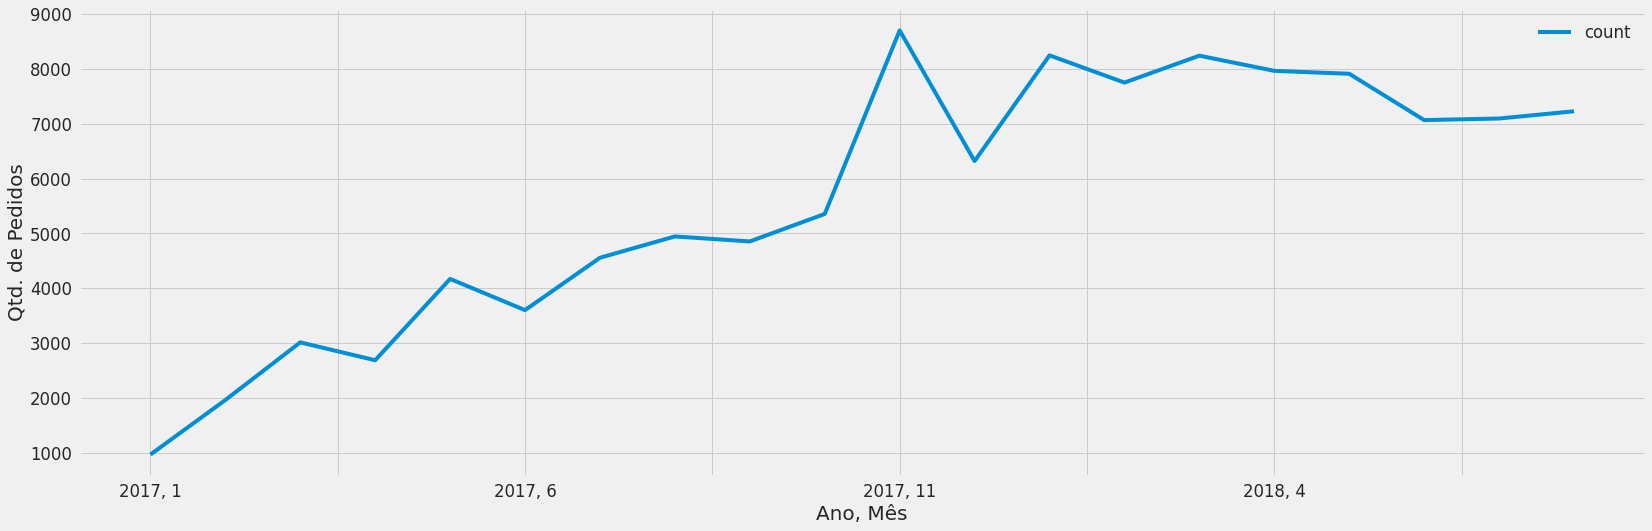

In [501]:
months_portchases.plot(x='year_month', y='count', figsize=(25,8))#, color='#42A5F5', alpha=0.9, ci=None)
plt.xlabel('Ano, Mês', size=20)
plt.ylabel('Qtd. de Pedidos', size=20)

print(r'Gráfico I')
plt.show()

In [502]:
freight_delivery_time_avg = dataset.groupby('customer_state', as_index=False)['delivery_time'].mean().sort_values(by='customer_state')
freight_delivery_time_avg

,customer_state,delivery_time
0,AC,20.68
1,AL,24.44
2,AM,26.30
3,AP,28.22
4,BA,19.19
5,CE,20.94
6,DF,12.87
7,ES,15.55
8,GO,15.33
9,MA,21.43


Gráfico II


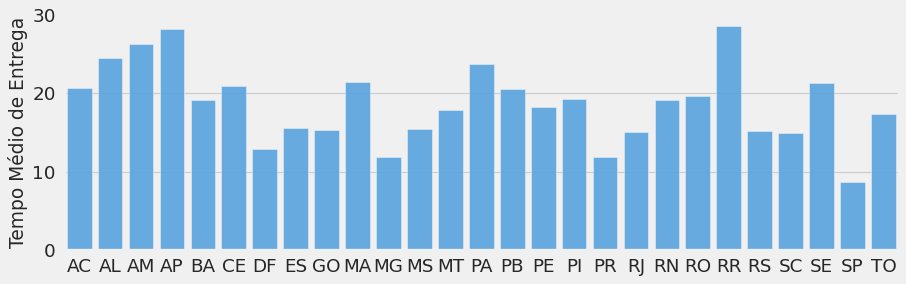

In [503]:
print(r'Gráfico II')
figure(num=None, figsize=(12, 8), dpi=80)
plt.subplot(2, 1, 1)
sns.barplot(x=freight_delivery_time_avg['customer_state'], y=freight_delivery_time_avg['delivery_time'], color='#42A5F5', alpha=0.9)
plt.xlabel(None)
plt.ylabel('Tempo Médio de Entrega')
plt.show()

In [504]:
delivery_time_sp = freight_delivery_time_avg[freight_delivery_time_avg['customer_state']=='SP']
value = delivery_time_sp['delivery_time'].values.round()
value[0]

9.0

In [505]:
def issue_alert(delivery_time_sp, value_avg):
  if delivery_time_sp > value_avg:
    print('Alerta: ' + 'Entrega realizada em: ' + str(delivery_time_sp) + ' dias. Acima do normal.')

In [506]:
issue_alert(10.00, value[0])

Alerta: Entrega realizada em: 10.0 dias. Acima do normal.


In [507]:
state_portchases = dataset.groupby('customer_state', as_index=False)['price'].sum().sort_values(by='customer_state')
state_portchases_avg = dataset.groupby('customer_state', as_index=False)['price'].mean().sort_values(by='customer_state')
freight_avg = dataset.groupby('customer_state', as_index=False)['freight_value'].mean().sort_values(by='customer_state')

print('Tabela 1')
state_portchases_avg['price'].describe()

Tabela 1


count    27.00
mean    145.18
std      21.17
min     109.55
25%     124.64
50%     144.98
75%     158.72
max     189.98
Name: price, dtype: float64

Gráfico III


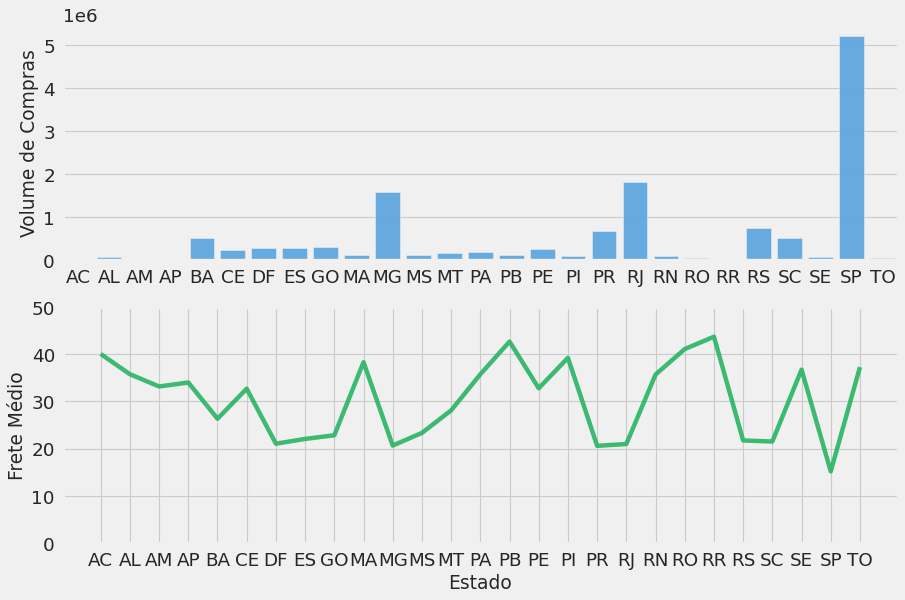

In [508]:
figure(num=None, figsize=(12, 8), dpi=80)

plt.subplot(2, 1, 1)
sns.barplot(x=state_portchases['customer_state'], y=state_portchases['price'], color='#42A5F5', alpha=0.9)
plt.xlabel(None)
plt.ylabel('Volume de Compras')

plt.subplot(2, 1, 2)
sns.lineplot(x=freight_avg['customer_state'], y=freight_avg['freight_value'], color='#28B463', alpha=0.9)
#ylim(top=3)  # adjust the top leaving bottom unchanged
plt.ylim(0,50)
plt.xlabel('Estado')
plt.ylabel('Frete Médio')

print(r'Gráfico III')
plt.show()

Gráfico IV


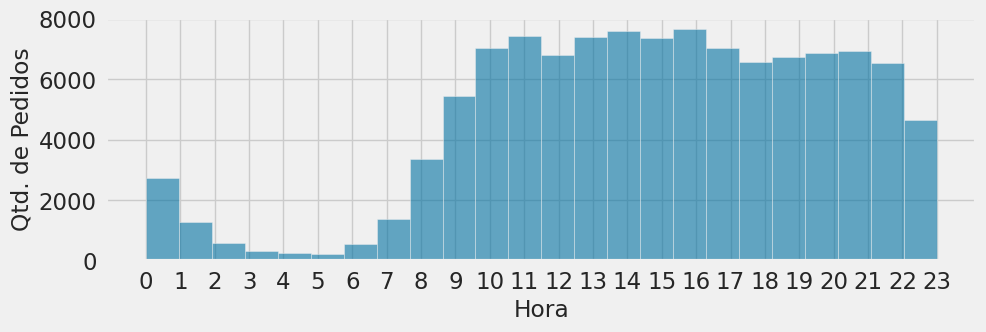

In [509]:
dataset['purchase_hour'] = dataset['order_purchase_timestamp'].dt.hour

figure(num=None, figsize=(10, 3), dpi=100)
plt.hist(dataset['purchase_hour'], bins=24, facecolor='b', alpha=0.6)
plt.xticks(ticks=np.arange(24))
plt.xlabel('Hora')
plt.ylabel('Qtd. de Pedidos')

print(r'Gráfico IV')
plt.show()

In [510]:
cus_value = dataset.groupby('customer_unique_id', as_index=False)['price'].sum() #price_x
cus_qtd = dataset.groupby('customer_unique_id', as_index=False)['price'].count() #price_y
cus_freight = dataset.groupby('customer_unique_id', as_index=False)['freight_value'].sum()
cus_loc = dataset[['customer_unique_id', 'geolocation_lat', 'geolocation_lng', 'customer_state']].drop_duplicates('customer_unique_id')
cus_review = dataset.groupby('customer_unique_id', as_index=False)['review_score'].mean()

#União das informações em um Dataframe
customer = cus_value.merge(cus_qtd, on='customer_unique_id')
customer = customer.merge(cus_freight, on='customer_unique_id')
customer = customer.merge(cus_loc, on='customer_unique_id')
customer = customer.merge(cus_review, on='customer_unique_id')
customer = customer.rename(columns={'price_x':'price', 'price_y':'count_items'})

print('Média do valor de compra: R$ ' + str(round(customer['price'].mean(),2)) + '\nDesvio Padrão: R$ ' + str(round(customer['price'].std(),2)))
customer.sort_values(by='price', ascending=False).head(10)

Média do valor de compra: R$ 143.0
Desvio Padrão: R$ 218.97


,customer_unique_id,price,count_items,freight_value,geolocation_lat,geolocation_lng,customer_state,review_score
3772,0a0a92112bd4c708ca5fde585afaa872,13440.00,8,224.08,-22.90,-43.18,RJ,1.00
80906,da122df9eeddfedc1dc1f5349a1a690c,7388.00,2,183.63,-22.87,-42.27,RJ,5.00
43891,763c8b1c9c68a0229c42c9fc6f662b93,7160.00,4,114.88,-20.38,-40.31,ES,1.00
81746,dc4802a71eae9be1dd28f5d788ceb526,6735.00,1,194.31,-20.50,-54.57,MS,5.00
25865,459bef486812aa25204be022145caa62,6729.00,1,193.21,-20.27,-40.28,ES,1.00
94572,ff4159b92c40ebe40454e3e6a7c35ed6,6499.00,1,227.66,-22.21,-49.95,SP,5.00
23805,4007669dec559734d6f53e029e360987,5934.60,6,146.94,-20.16,-44.88,MG,1.00
88532,eebb5dda148d3893cdaf5b5ca3040ccb,4690.00,1,74.34,-23.68,-46.42,SP,4.00
34622,5d0a2980b292d049061542014e8960bf,4599.90,2,209.54,-16.69,-49.28,GO,1.00
27084,48e1ac109decbb87765a3eade6854098,4590.00,1,91.78,-7.10,-34.84,PB,5.00


In [511]:
result = dataset[['customer_unique_id','review_score', 'review_comment_message']][
    (dataset['customer_unique_id'] == '0a0a92112bd4c708ca5fde585afaa872')
    |(dataset['customer_unique_id'] == '763c8b1c9c68a0229c42c9fc6f662b93')
    |(dataset['customer_unique_id'] == '459bef486812aa25204be022145caa62')]
print('Comentários por parte dos consumidores que pontuarão a avaliação com nota 1.00')
print('')
print('CONSUMIDOR 1: ' + result.groupby('customer_unique_id')['review_comment_message'].min()[0])
print('CONSUMIDOR 2: ' + result.groupby('customer_unique_id')['review_comment_message'].min()[1])
print('CONSUMIDOR 3: ' + result.groupby('customer_unique_id')['review_comment_message'].min()[2])

Comentários por parte dos consumidores que pontuarão a avaliação com nota 1.00

CONSUMIDOR 1: Peço por favor verificar a entrega do pedido, pois não recebemos.
CONSUMIDOR 2: Demora no retorno sobre o endereço de entrega
CONSUMIDOR 3: Comprei 04 unidades, e foram entregues apenas 02 pacotes com 01 unidade cada. Ainda não sei se serão entregues as outras 02 unidades faltantes.
De qualquer forma, a entrega deve ser de uma única vez.


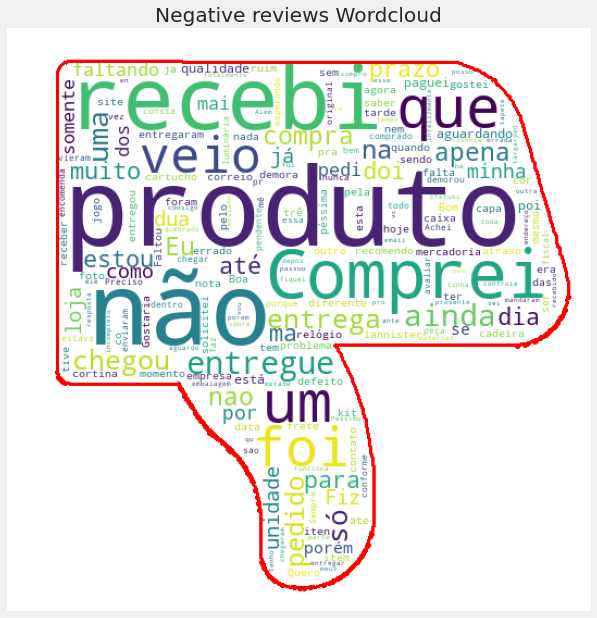

In [512]:
negReviewsText = dataset[dataset.review_score <3]['review_comment_message'].dropna()

# Words to desconsider on the visualization
stopwords = set(STOPWORDS)
stopwords.update(["/n" ,"da", "meu", "em", "você", "de", "ao", "os", "e", 'ou', 'é'])
 

def open_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_np = np.array(img)
    return img_np

mask = open_img('https://cdn-images-1.medium.com/max/537/1*CK7ulJRe6nqeorManOJUzg.png')


# WordCLoud generate
wordcloudInst = WordCloud(stopwords=stopwords,
                      background_color="white",
                      random_state=1,
                    #   colormap='Reds', 
                      mask=mask,
                      contour_width=2, 
                      contour_color='Red',
                      collocations=False, 
                      repeat = False,                   
                      width=700, height=700).generate(negReviewsText.to_string(index=False))
 
# Configure visualization of the image
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloudInst, interpolation='bilinear')
ax.set_axis_off()
 
#Show Img 
plt.title('Negative reviews Wordcloud')
plt.imshow(wordcloudInst)

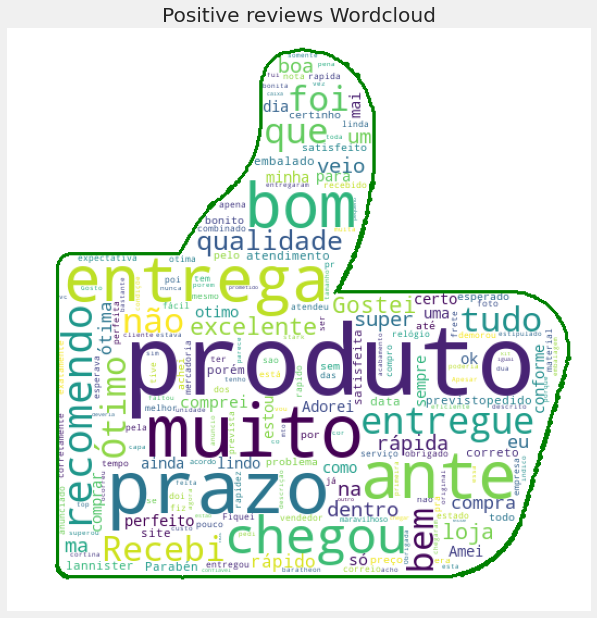

In [513]:
posReviewsText = dataset[dataset.review_score >=3]['review_comment_message'].dropna()

mask = open_img("https://cdn-images-1.medium.com/max/537/1*q4vrNnlsX_d4glglS35AGw.png")


# WordCLoud generate
wordcloudInst = WordCloud(stopwords=stopwords,
                      background_color="white",
                      random_state=1,
                    #   colormap='Greens', 
                      mask=mask,
                      contour_width=2, 
                      contour_color='Green',  
                      collocations=False, 
                      repeat = False,    
                      width=700, height=700).generate(posReviewsText.to_string(index=False))
 
# Configure visualization of the image
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloudInst, interpolation='bilinear')
ax.set_axis_off()
 
#Show Img 
plt.title('Positive reviews Wordcloud')
plt.imshow(wordcloudInst)

In [514]:
dataTime = dataset[['order_id', 'order_purchase_timestamp', 'price']].set_index('order_purchase_timestamp', inplace=False)

dataTimeMean = pd.DataFrame(dataTime.resample('W')['price'].sum()) #resample using weeks as parameter
# dataTimeMean = dataTimeMean.fillna(0)
dataTimeMean.drop(dataTimeMean.tail(8).index, inplace=True) # Drop the last observations with 0 

In [515]:
#Decompose Time Series
#decompose = seasonal_decompose(dataTimeMean, extrapolate_trend=12)
decompose = seasonal_decompose(dataTimeMean, period=len(dataTimeMean) // 2, model='multiplicative')

#Trend
obs = decompose.observed
#Trend
trend = decompose.trend
#Seazonal
seazon = decompose.seasonal
#Error
random = decompose.resid

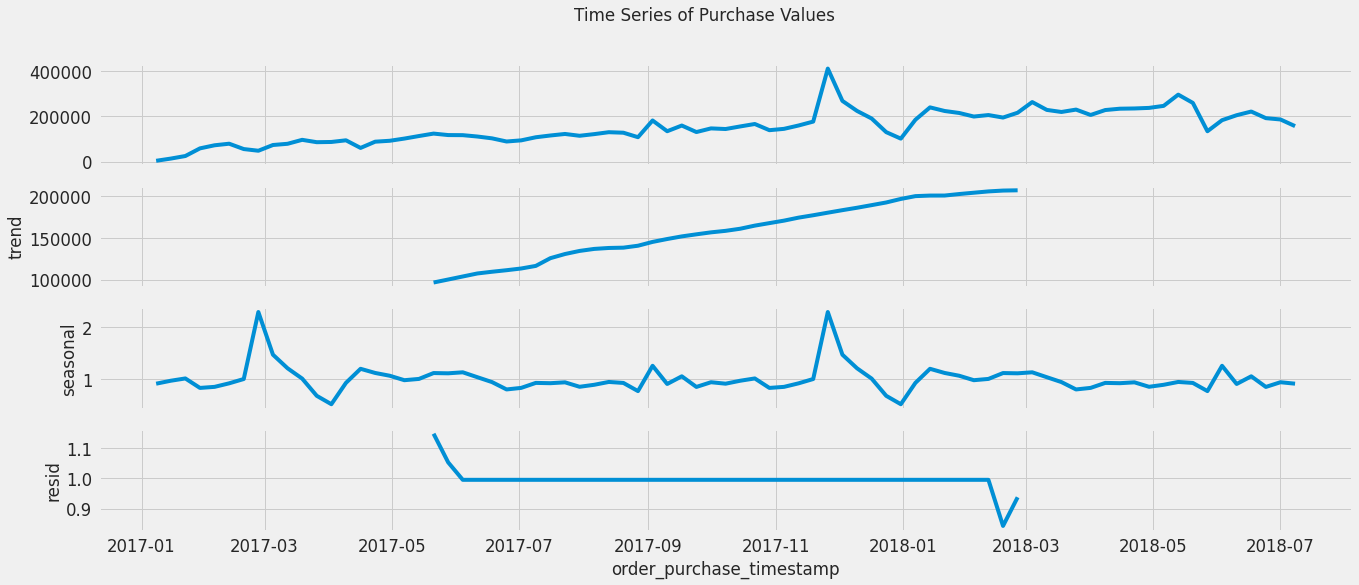

In [516]:
fig, axes = plt.subplots(4, 1, figsize=(20,8), sharex=True)
fig.suptitle('Time Series of Purchase Values')

sns.lineplot(x=obs.index, y=obs, ax=axes[0], data=obs)
sns.lineplot(x=trend.index, y=trend, ax=axes[1], data=trend)
sns.lineplot(x=seazon.index, y=seazon, ax=axes[2], data=seazon)
sns.lineplot(x=random.index, y=random, ax=axes[3], data=random)

In [517]:
adf = ADFTest(alpha=0.05)
adf.is_stationary(dataTimeMean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.



(0.12433172918030147, True)

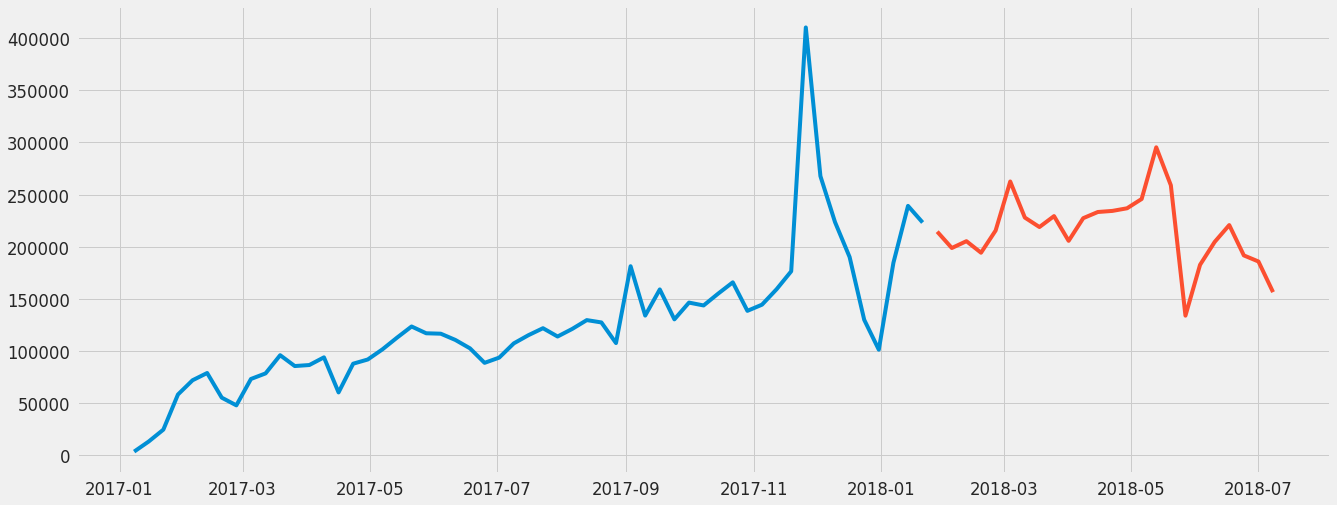

In [518]:
#dataTimeMean = dataTimeMean.drop(columns=['pred_1', 'x1'], axis=0)
training, testing = model_selection.train_test_split(dataTimeMean, train_size=0.70)
#train_size = int(len(dataTimeMean.price) * 2 / 3)
#train = dataTimeMean[:train_size]
#test = dataTimeMean[train_size-1:]
fig, axes = plt.subplots(1, 1, figsize=(20,8), sharex=True)
plt.plot(training)
plt.plot(testing)

In [519]:
auto_arima_model = auto_arima(training, m=12, seazonal=True, trace=False, random_state=1, n_fits=50)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   55
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -512.979
Date:                            Fri, 08 Apr 2022   AIC                           1031.958
Time:                                    03:29:54   BIC                           1037.242
Sample:                                         0   HQIC                          1033.906
                                             - 55                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.957e+04   1.05e+04      1.868      0.062    -961.251    4.01e+04
ar.L1          0.5227      0.176      2.976      0.003       0.178       0.867
sigma2      1.371e+09      0.045   3.01e+10      0.000    1.37e+09    1.37e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               193.63
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               8.47   Skew:                             2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.89e+28. Standard errors may be unstable.
"""

In [593]:
#dateRange = pd.date_range(dataTimeMean.index[-1], freq='W', periods=13)[1:]
predict = pd.DataFrame(auto_arima_model.predict(n_periods=len(testing)), index=testing.index)
#predict = auto_arima_model.predict(n_periods=test.shape[0])
predict.columns = ['price']
#predict.price = predict.price.round(2)
#print('Next weeks pridiction from auto-ARIMA')
#print(predict)

In [594]:
predict.head()

,price
order_purchase_timestamp,
2018-01-28,208235.25
2018-02-04,212149.75
2018-02-11,223658.01
2018-02-18,454635.52
2018-02-25,310442.71


In [595]:
training.head()

,price
order_purchase_timestamp,
2017-01-08,3374.76
2017-01-15,13087.14
2017-01-22,24446.26
2017-01-29,58152.49
2017-02-05,71820.33


In [596]:
testing.head()

,price
order_purchase_timestamp,
2018-01-28,214410.36
2018-02-04,198717.59
2018-02-11,205281.11
2018-02-18,194207.04
2018-02-25,215503.64


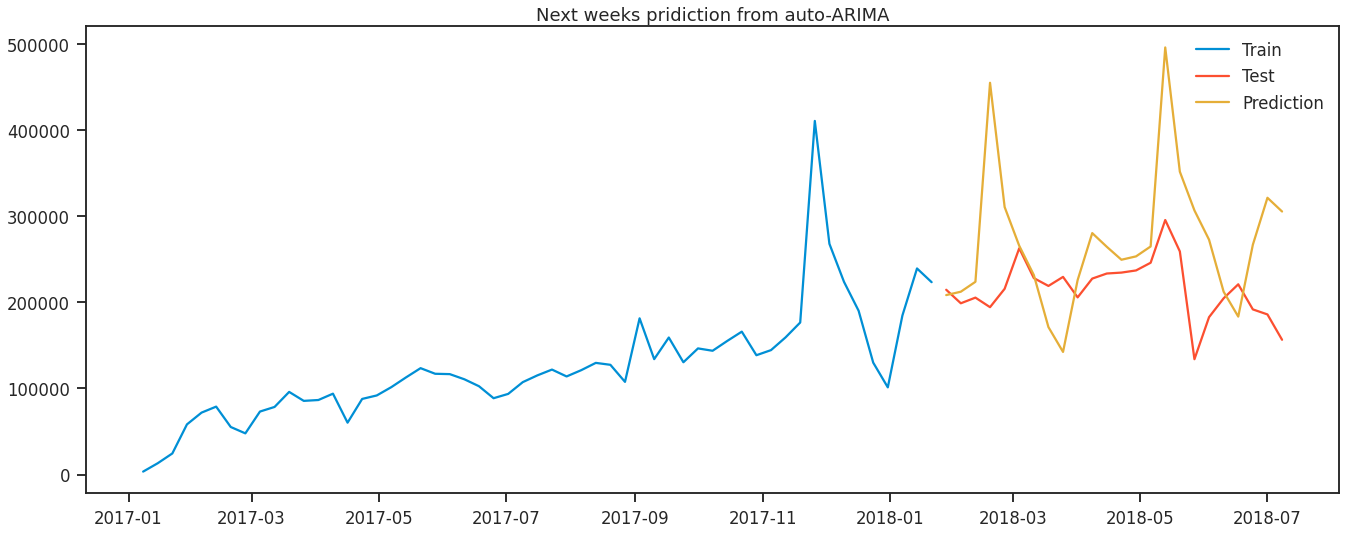

In [597]:
plt.figure(figsize=(20,8))
plt.ticklabel_format(useOffset=False, style='plain')
plt.plot(training, label = 'Train')
plt.plot(testing, label = 'Test')
plt.plot(predict, label = 'Prediction')
plt.title('Next weeks pridiction from auto-ARIMA')
plt.legend(loc='best')
plt.show()

In [525]:
df_prophet = training.copy()

In [526]:
df_prophet = df_prophet.reset_index().rename(columns={'order_purchase_timestamp': 'ds', 'price': 'y'})
df_prophet.head()

,ds,y
0,2017-01-08,3374.76
1,2017-01-15,13087.14
2,2017-01-22,24446.26
3,2017-01-29,58152.49
4,2017-02-05,71820.33


In [527]:
model_prophet = Prophet(seasonality_mode='multiplicative', interval_width=0.99, seasonality_prior_scale=10)

In [528]:
#model_prophet.add_seasonality(name='weekly', period=7, fourier_order=4, prior_scale=0.01)

In [529]:
model_prophet.fit(df_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:401: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [530]:
periods = testing.shape[0]
future = model_prophet.make_future_dataframe(periods=periods, freq="W")
forecast = model_prophet.predict(future)

In [531]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-08,37116.89,-70103.30,139459.91,37116.89,37116.89,0.00,0.00,0.00,0.00,0.00,0.00,37116.89
1,2017-01-15,40333.12,-66822.64,147578.74,40333.12,40333.12,0.00,0.00,0.00,0.00,0.00,0.00,40333.12
2,2017-01-22,43549.34,-54777.11,137261.39,43549.34,43549.34,0.00,0.00,0.00,0.00,0.00,0.00,43549.34
3,2017-01-29,46765.57,-50499.36,145365.64,46765.57,46765.57,0.00,0.00,0.00,0.00,0.00,0.00,46765.57
4,2017-02-05,49981.80,-54452.90,154220.85,49981.80,49981.80,0.00,0.00,0.00,0.00,0.00,0.00,49981.80
5,2017-02-12,53198.03,-53011.59,153305.29,53198.03,53198.03,0.00,0.00,0.00,0.00,0.00,0.00,53198.03
6,2017-02-19,56414.26,-44199.92,157078.15,56414.26,56414.26,0.00,0.00,0.00,0.00,0.00,0.00,56414.26
7,2017-02-26,59630.49,-45209.21,168548.30,59630.49,59630.49,0.00,0.00,0.00,0.00,0.00,0.00,59630.49
8,2017-03-05,62846.72,-42929.38,158920.33,62846.72,62846.72,0.00,0.00,0.00,0.00,0.00,0.00,62846.72
9,2017-03-12,66062.95,-33535.80,166826.82,66062.95,66062.95,0.00,0.00,0.00,0.00,0.00,0.00,66062.95


In [532]:
forecast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
69,2018-05-06,259036.72,166691.61,359627.71,259036.71,259036.73,0.00,0.00,0.00,0.00,0.00,0.00,259036.72
70,2018-05-13,262252.95,152932.36,380455.90,262252.94,262252.96,0.00,0.00,0.00,0.00,0.00,0.00,262252.95
71,2018-05-20,265469.18,161438.24,356509.15,265469.17,265469.19,0.00,0.00,0.00,0.00,0.00,0.00,265469.18
72,2018-05-27,268685.41,162551.05,366409.08,268685.40,268685.42,0.00,0.00,0.00,0.00,0.00,0.00,268685.41
73,2018-06-03,271901.64,162844.72,381705.88,271901.63,271901.65,0.00,0.00,0.00,0.00,0.00,0.00,271901.64
74,2018-06-10,275117.87,166662.56,379165.72,275117.85,275117.88,0.00,0.00,0.00,0.00,0.00,0.00,275117.87
75,2018-06-17,278334.10,154762.49,387635.46,278334.08,278334.11,0.00,0.00,0.00,0.00,0.00,0.00,278334.10
76,2018-06-24,281550.32,171447.15,389296.11,281550.31,281550.34,0.00,0.00,0.00,0.00,0.00,0.00,281550.32
77,2018-07-01,284766.55,186211.84,382840.09,284766.54,284766.57,0.00,0.00,0.00,0.00,0.00,0.00,284766.55
78,2018-07-08,287982.78,194075.22,394046.31,287982.77,287982.80,0.00,0.00,0.00,0.00,0.00,0.00,287982.78


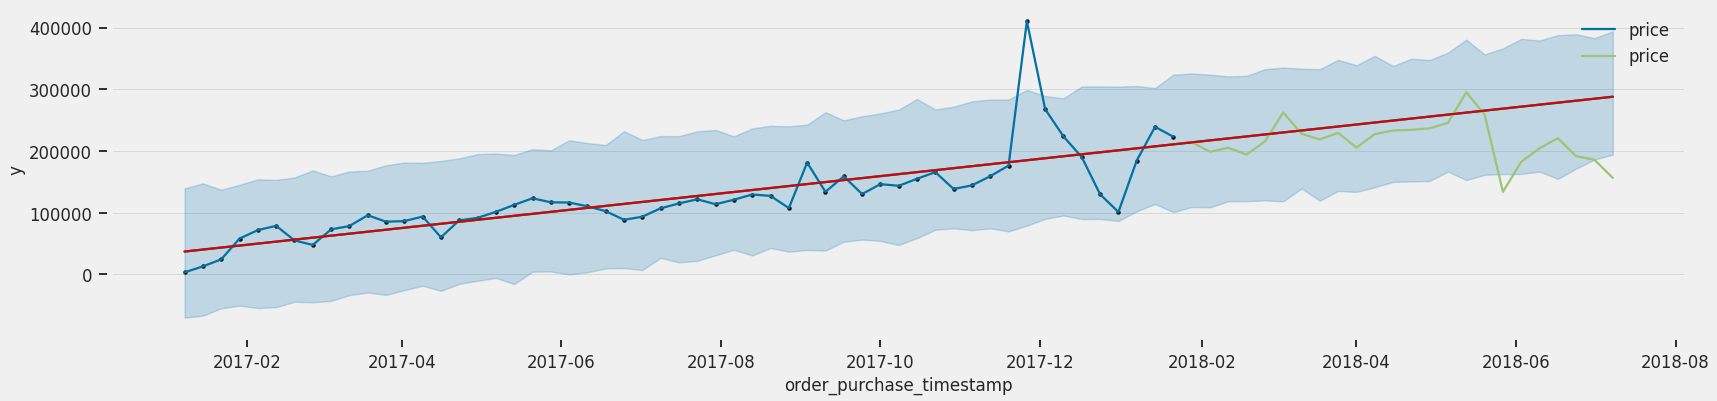

In [533]:
fig, ax= plt.subplots(1, 1, figsize=(24, 6))
sns.set_style("ticks")

sns.set_context("talk")
model_prophet.plot(forecast, ax=ax);
training.plot(ax=ax, c="b");
testing.plot(ax=ax, c="g");
ax.yaxis.grid(True)
add_changepoints_to_plot(fig.gca(), model_prophet, forecast)
sns.despine(offset=5, trim=False)

In [535]:
df_cv = cross_validation(model_prophet, horizon='30 days', period='10 days', initial='1 days', parallel='processes')

INFO:fbprophet:Making 35 forecasts with cutoffs between 2017-01-16 00:00:00 and 2017-12-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcfcf588710>
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:401: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

INFO:fbprophet:n_changepoints greater than number of observations. Usin

In [536]:
df_p = performance_metrics(df_cv)
df_p.head(10)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,1133044077.25,33660.72,23801.90,0.23,0.12,0.87
1,4 days,4645624916.91,68158.82,35534.33,0.25,0.12,0.80
2,5 days,4267116689.25,65323.17,33049.60,0.23,0.12,0.80
3,6 days,4176745234.55,64627.74,30281.26,0.19,0.12,0.80
4,7 days,234696621.28,15319.81,13544.92,0.13,0.10,0.93
5,8 days,296108031.79,17207.79,14431.77,0.14,0.12,0.93
6,9 days,1078228423.29,32836.39,19722.82,0.19,0.08,0.93
7,10 days,1435570311.07,37888.92,25740.69,0.27,0.12,0.73
8,11 days,2285591771.65,47807.86,34316.53,0.37,0.15,0.60
9,12 days,1884173191.05,43407.06,31244.30,0.32,0.14,0.67


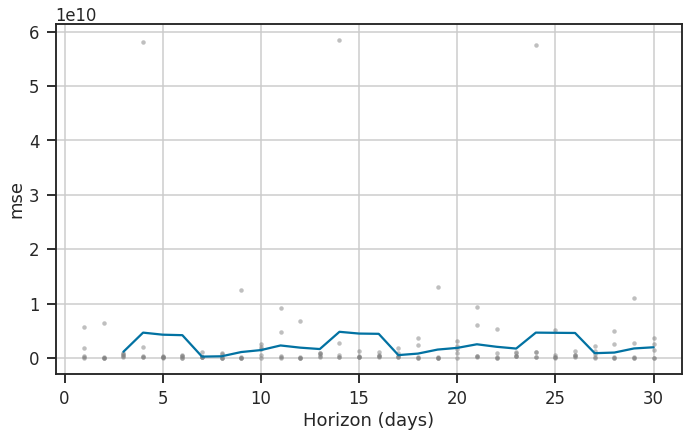

In [537]:
fig = plot_cross_validation_metric(df_cv, metric='mse')
plt.show()

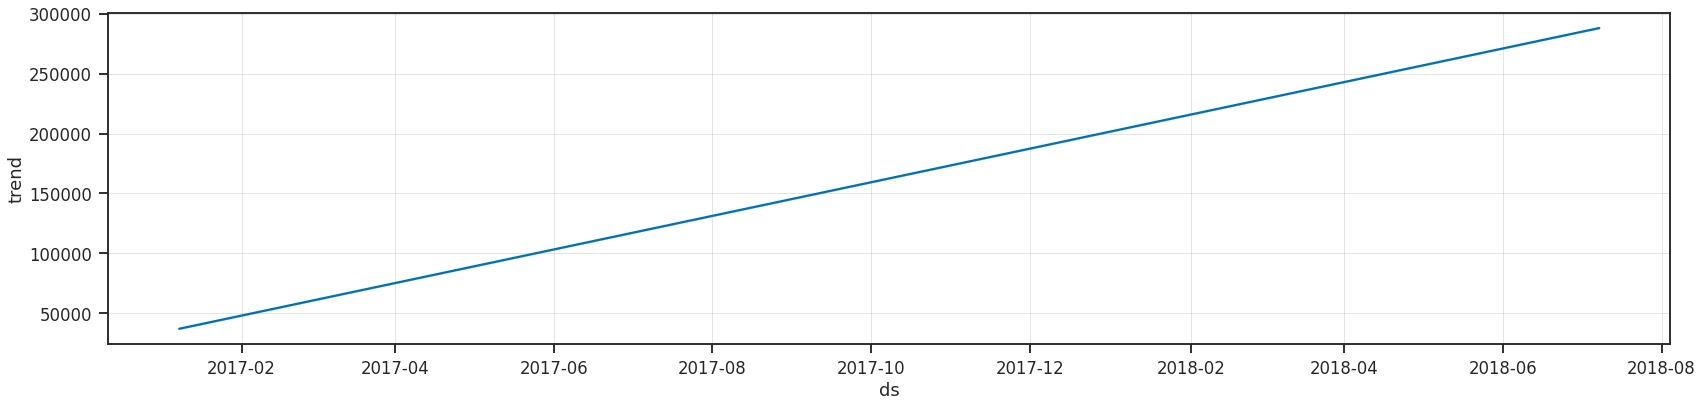

In [538]:
fig = model_prophet.plot_components(forecast, figsize=(24,6))

In [539]:
dataTimeMean['x1'] = dataTimeMean.price.shift(1)
dataTimeMean.dropna(axis=0, inplace=True)
dataTimeMean.head()

,price,x1
order_purchase_timestamp,,
2017-01-15,13087.14,3374.76
2017-01-22,24446.26,13087.14
2017-01-29,58152.49,24446.26
2017-02-05,71820.33,58152.49
2017-02-12,78777.53,71820.33


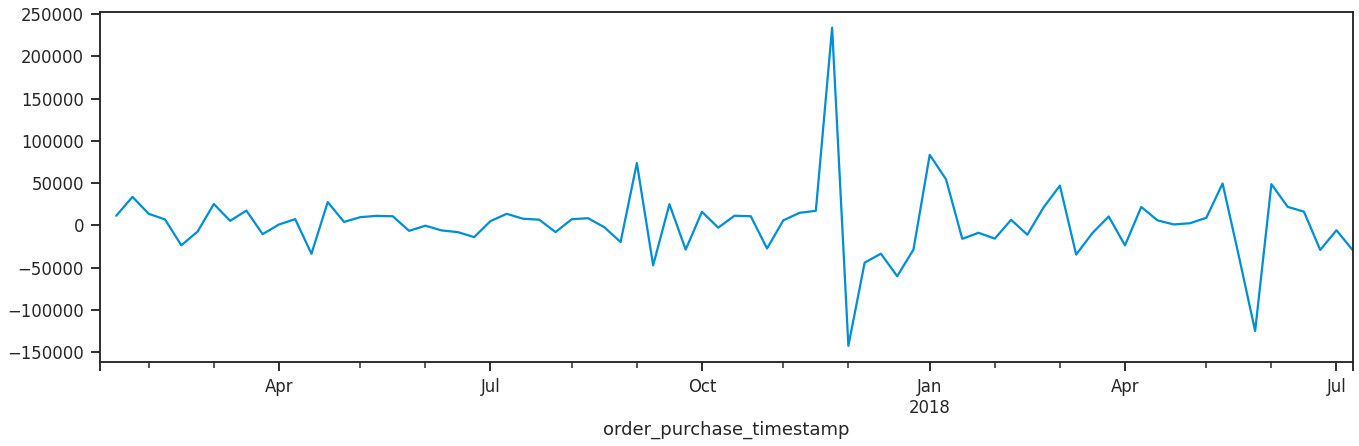

In [540]:
dataTimeMean.price.diff(1).plot(figsize=(20, 6))

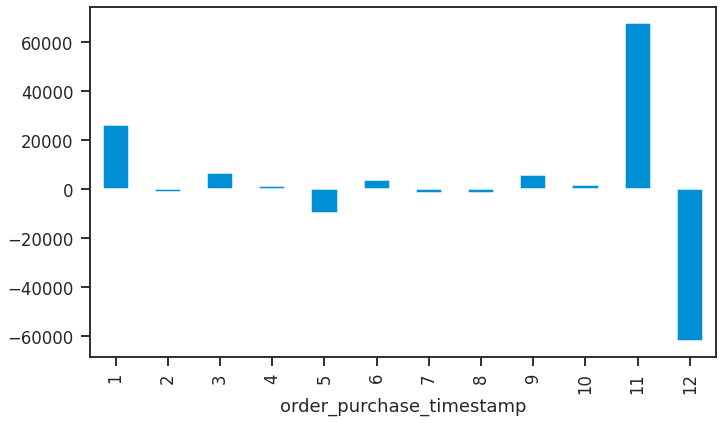

In [541]:
dataTimeMean.price.diff(1).groupby(dataTimeMean.index.month).mean().plot(kind='bar', figsize=(10, 6))

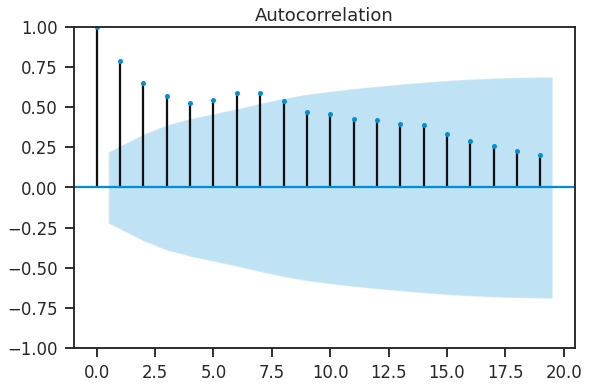

In [542]:
plot_acf(dataTimeMean.price)
plt.show()

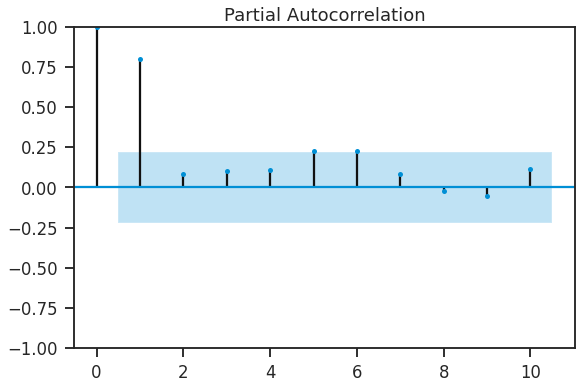

In [543]:
plot_pacf(dataTimeMean.price, lags=10)
plt.show()

In [544]:
X = dataTimeMean[['x1']]
y = dataTimeMean.price.values

In [545]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

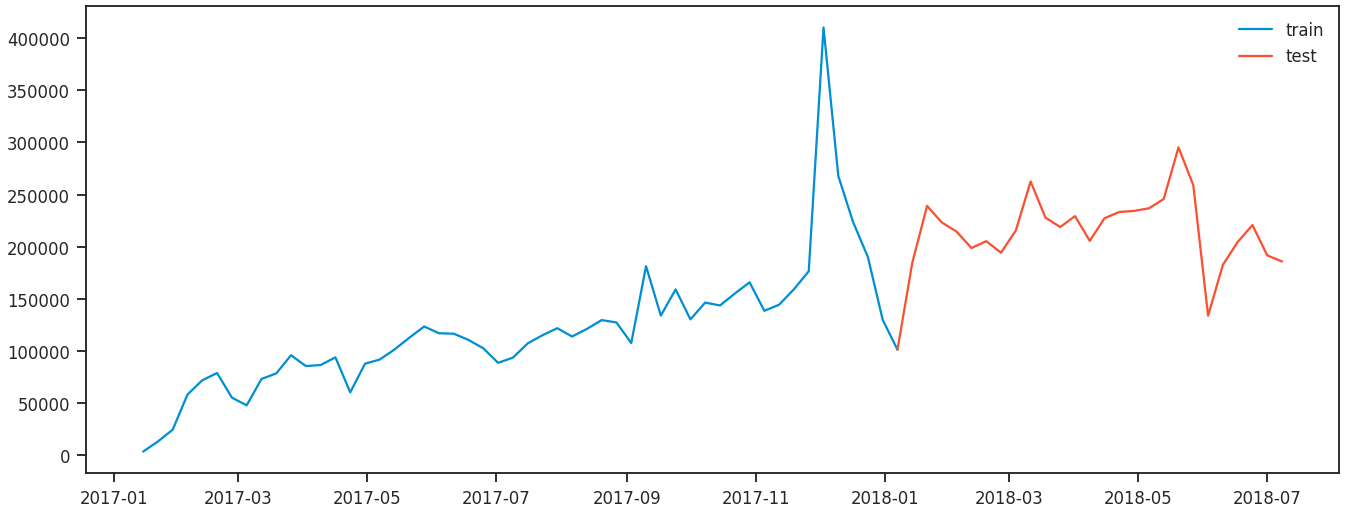

In [546]:
fig, axes = plt.subplots(1, 1, figsize=(20,8), sharex=True)
train_size = int(len(dataTimeMean.price) * 2 / 3)
train = X[:train_size]
test = X[train_size-1:]
plt.plot(train)
plt.plot(test)
plt.legend(['train', 'test'])

In [554]:
X_train.shape, y_train.shape

((54, 1), (54,))

In [555]:
X_test.shape, y_test.shape

((24, 1), (24,))

In [556]:
linear_regression = LinearRegression().fit(X_train,y_train)
linear_regression

LinearRegression()

In [557]:
# b0
linear_regression.intercept_

33595.091731492954

In [558]:
# b1
linear_regression.coef_

array([0.77370684])

In [559]:
linear_regression.score(X_train, y_train)

0.7684279198329615

In [560]:
linear_regression.score(X_test, y_test)

0.48819855267383006

In [561]:
predictionsLinear_train = linear_regression.predict(X_train)
predictionsLinear_train

array([206293.71635326, 112068.19991563, 200331.73258854, 209956.56833887,
        76249.19405475, 199485.85437174, 233925.89026427,  89162.9724849 ,
       116781.08814258, 176400.59309582, 127813.27342825,  99713.77284729,
       134051.36221679, 112867.75630377, 107760.37816903, 133824.99106881,
       145283.39597989, 236737.68019723,  43720.70149858, 132092.83940097,
       214082.83977487,  80140.52940802, 218609.78303635, 129087.03474017,
       121644.93431156, 102098.43791784, 137183.42809722, 120767.54301507,
        36206.16663537, 181849.92644375, 101462.11819934,  94545.80572971,
       216836.3927938 , 104576.99231373, 111844.47484505, 124049.58422986,
       137112.28575305,  90120.45017666, 106176.01998225, 105969.56404839,
       134377.7040259 , 351098.10481939, 144702.81410233, 209505.48951261,
       183854.40744602, 100476.65553109, 156595.93393995, 123727.64481268,
        94254.44320695, 191839.07753502, 214901.27460997, 192658.92051656,
       240741.58989609, 1

In [562]:
grafico = px.scatter(x = X_train.x1.ravel(), y = predictionsLinear_train)
grafico.show()

In [563]:
grafico1 = px.scatter(x = X_train.x1.ravel(), y = y_train)
grafico2 = px.line(x = X_train.x1.ravel(), y = predictionsLinear_train)
grafico2.data[0].line.color = 'red'
grafico3 = go.Figure(data=grafico1.data + grafico2.data)
grafico3

In [564]:
predictionsLinear_test = linear_regression.predict(X_test)
predictionsLinear_test

array([180637.4581879 , 122610.27286484, 127259.67844536, 211037.13505221,
       170081.04071383, 223743.65289338, 174863.50066005, 204379.42635762,
       206580.11167809, 192422.49117962, 153504.12402654, 202918.55178291,
        52509.33036764, 262110.35933067, 187344.25084457, 173839.65439534,
        78588.07115436, 119091.44640797,  70538.11568199, 116536.82115532,
       140704.41319619, 146820.89074322, 161873.91443347, 177334.03171598])

In [565]:
y_test

array([129837.64, 121775.04, 129545.06, 205586.69, 410366.04, 295351.23,
       204527.06, 191616.29, 190049.2 , 194207.04, 165797.71, 229340.15,
        58152.49, 258923.39, 205281.11, 133885.77,  71820.33, 102458.27,
        73057.85, 115050.27, 144354.81, 143604.42, 138436.57, 156378.31])

In [566]:
abs(y_test - predictionsLinear_test).mean().round()

25671.0

In [567]:
grafico1 = px.scatter(x = X_test.x1.ravel(), y = y_test)
grafico2 = px.line(x = X_test.x1.ravel(), y = predictionsLinear_test)
grafico2.data[0].line.color = 'red'
grafico3 = go.Figure(data=grafico1.data + grafico2.data)
grafico3.show()

In [568]:
print('MSE for Linear Regression was: \n', mean_squared_error(y_test, predictionsLinear_test))
print('RMSE for Linear Regression was: \n', np.sqrt(mean_squared_error(y_test, predictionsLinear_test)))
print('MAE for Linear Regression was: \n', mean_absolute_error(y_test, predictionsLinear_test))

MSE for Linear Regression was: 
 2956353361.198143
RMSE for Linear Regression was: 
 54372.358429611486
MAE for Linear Regression was: 
 25671.200153538306


In [569]:
xgb = XGBRegressor(n_estimators=150, learning_rate=0.05)
xgb.fit(X, y, 
        early_stopping_rounds=5, 
        eval_set=[(X, y)], 
        verbose=False
)

predictions_XGBoost = xgb.predict(X)

print('RMSE for xgb was: \n', mean_squared_error(y, predictions_XGBoost, squared=False))

[03:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for xgb was: 
 16427.85974672986


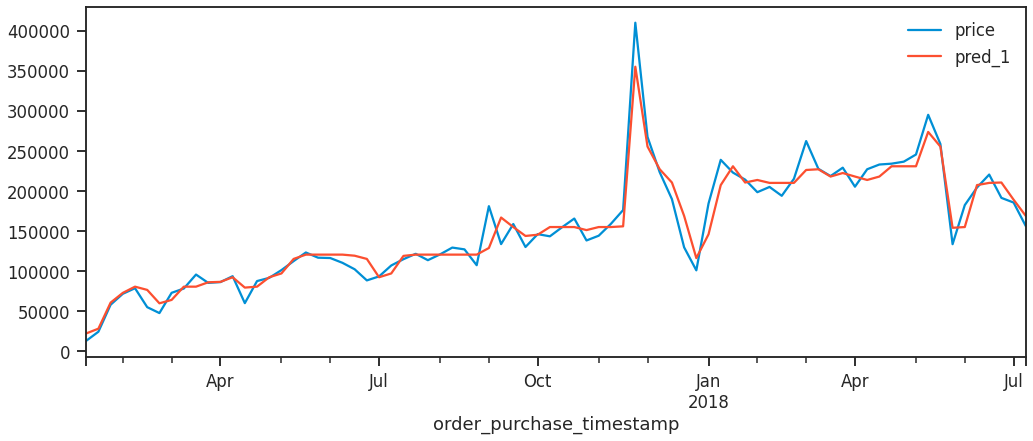

In [570]:
dataTimeMean['pred_1'] = xgb.predict(X)
dataTimeMean[['price', 'pred_1']].plot(figsize=(15, 6))

In [571]:
random_forest = RandomForestRegressor(min_samples_leaf = 1, min_samples_split=5, n_estimators = 500, random_state=0)
random_forest.fit(X, y)
predictions_RandomForest = random_forest.predict(X)
print('RMSE for Random Forest was: \n', mean_squared_error(y, predictions_RandomForest, squared=False))

RMSE for Random Forest was: 
 21276.5381193415


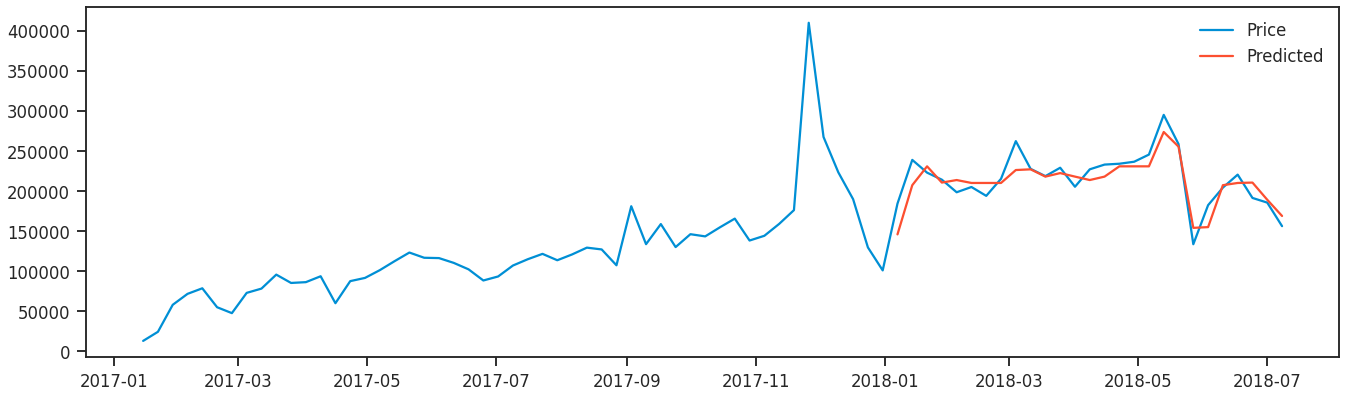

In [572]:
plt.figure(figsize=(20, 6))
plt.plot(dataTimeMean.price)
forecast = xgb.predict(test)
plt.plot(test.index, forecast)
plt.legend(['Price', 'Predicted'])

In [573]:
lastPrice = dataTimeMean['price'][-1]
datesToPredict = pd.Series(dataTimeMean.index[-1] + pd.Timedelta('1w'))
forecastData =  pd.DataFrame({'x1': str(lastPrice)}, index=datesToPredict)  
forecastData.x1 = pd.to_numeric(forecastData.x1)
print("Next week's predicted price is: R$", xgb.predict(forecastData))

Next week's predicted price is: R$ [155184.72]


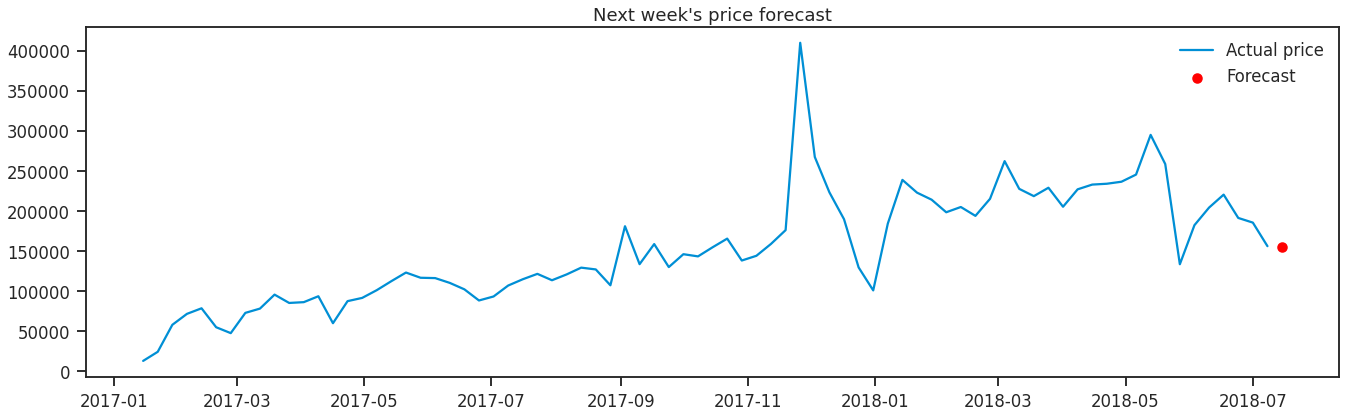

In [574]:
plt.figure(figsize=(20, 6))
plt.plot(dataTimeMean.price)
forecast = xgb.predict(test)
plt.scatter(forecastData.index, xgb.predict(forecastData), color='red')
plt.title("Next week's price forecast")
plt.legend(['Actual price', 'Forecast'])

In [575]:
resultados_linear_regression = []
resultados_random_forest = []
resultados_xgb = []
auto_arima = []

for i in range(20):
  print(i)
  kfold = KFold(n_splits=10, shuffle=True, random_state=i)
  
  scores = cross_val_score(linear_regression, X, y, cv = kfold)
  #print(scores)
  #print(scores.mean())
  resultados_linear_regression.append(scores.mean())
  
  scores = cross_val_score(random_forest, X, y, cv = kfold)
  resultados_random_forest.append(scores.mean())
  
  scores = cross_val_score(xgb, X, y, cv = kfold)
  resultados_xgb.append(scores.mean())  
  

0
[03:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:46:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of 

In [576]:
resultados = pd.DataFrame({'Linear Regression': resultados_linear_regression, 
                           'Random forest': resultados_random_forest,
                           'XGB': resultados_xgb
                          })
resultados

,Linear Regression,Random forest,XGB
0,0.64,0.52,0.58
1,0.57,0.49,0.52
2,0.68,0.58,0.57
3,0.68,0.55,0.57
4,0.67,0.53,0.53
5,0.52,0.36,0.46
6,0.69,0.63,0.65
7,0.69,0.58,0.62
8,0.68,0.61,0.63
9,0.59,0.42,0.47


In [577]:
resultados.describe()

,Linear Regression,Random forest,XGB
count,20.00,20.00,20.00
mean,0.64,0.54,0.57
std,0.05,0.08,0.07
min,0.52,0.36,0.45
25%,0.61,0.49,0.53
50%,0.65,0.55,0.58
75%,0.68,0.60,0.62
max,0.71,0.64,0.67


In [578]:
pickle.dump(linear_regression, open('linear_regression.sav', 'wb'))

In [579]:
pickle.dump(xgb, open('xgb.sav', 'wb'))

In [580]:
pickle.dump(random_forest, open('random_forest.sav', 'wb'))

In [581]:
pickle.dump(auto_arima_model, open('auto_arima_model.sav', 'wb'))

In [582]:
pickle.dump(model_prophet, open('model_prophet.sav', 'wb'))